In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Models2 import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import recall_score

# DATA

In [2]:
data = pd.read_csv("data/spam.csv",sep=",",encoding="ISO-8859-1").iloc[:,:2]
spam = data[data.iloc[:,0]=="spam"]
ham = data[data.iloc[:,0]=="ham"]
spam = spam.sample(len(ham), replace = True)
data = pd.concat([ham, spam], axis = 0)
X = data.iloc[:,1]
y = data.iloc[:,0]
y = pd.Series([1 if a=="spam" else 0 for a in y])
X_t, X_test, y_t, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t)

lengths = [len(a.split()) for a in X_train]

In [3]:
y_test

4636    0
593     0
2627    0
9302    1
5696    1
       ..
5752    1
4228    0
213     0
1669    0
8898    1
Length: 2413, dtype: int64

# Sentence length distribution

(array([2.346e+03, 2.929e+03, 1.200e+02, 1.600e+01, 9.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  17.1,  33.2,  49.3,  65.4,  81.5,  97.6, 113.7, 129.8,
        145.9, 162. ]),
 <BarContainer object of 10 artists>)

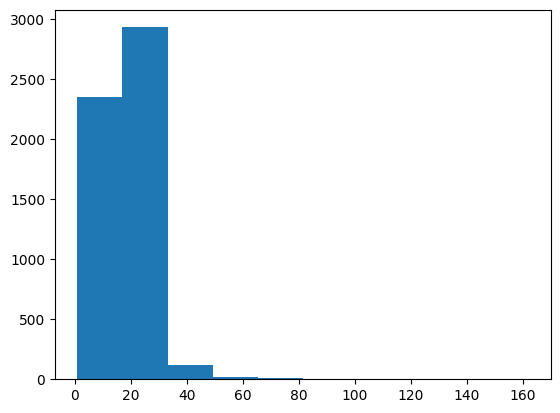

In [4]:
plt.hist(lengths)

# Tokenization

In [5]:
max_len = 70 
vocabulary_size = 20000 # random value
embed_size = 32    # random value 

tok = Tokenizer(num_words=vocabulary_size)
tok.fit_on_texts(X_train.values)


# Token 
X_train = tok.texts_to_sequences(X_train)
X_val = tok.texts_to_sequences(X_val)
X_test = tok.texts_to_sequences(X_test)

# Now we need to pad all the sequences based on the max value 

X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Visualisation of some sentences

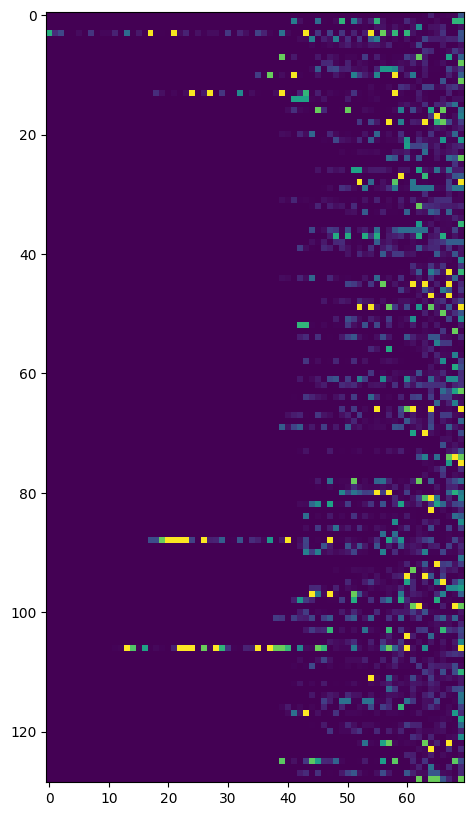

In [6]:
plt.figure(figsize=(10,10))
i=10
plt.imshow(X_train[129*i:129*(i+1)])


# Experiments

In [7]:
def experiment(train,val,max_len = 80, vocabulary_size = 20000, embed_size = 64,epochs=10):
    X_train,y_train = train
    X_val,y_val = val
    models = {}
    for model_fun,name in zip([get_small, get_medium],['small', 'medium']):
        for optimizer in ['adam', 'rmsprop']:
            for binary in [False, True]:
                model = model_fun(optimizer=optimizer,binary=binary,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
                model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
                b = "binary" if binary else "standard"
                models[name+"_"+b+"_"+optimizer] = model

    for binary in [False, True]:
        model = get_large(optimizer='adam',binary=binary,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
        model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
        b = "binary" if binary else "standard"
        models['large'+"_"+b+"_adam"] = model
                
    for optimizer in ['adam', 'rmsprop']:
        for lr in [0.01,0.001,0.0001]:
            model = get_small(optimizer=optimizer,lr=lr,binary=True,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
            model.fit(X_train,y_train,batch_size=256,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
            models["small_binary_lr="+str(lr)+"_"+optimizer] = model

    for optimizer in ['adam', 'rmsprop']:
        for bs in [32,128,256]:
            model = get_small(optimizer=optimizer,binary=True,max_len=max_len,vocabulary_size=vocabulary_size,embed_size=embed_size)
            model.fit(X_train,y_train,batch_size=bs,validation_data=(X_val,y_val),epochs=epochs,verbose=0)
            models["small_binary_bs="+str(bs)+"_"+optimizer] = model
    return models

In [8]:
def plot_diffrent_sizes(models):
    for metric in ["accuracy", "recall"]:
        for model in ['small', 'medium', 'large']:
            for binary in ["binary","standard"]:
                for optimizer in ['adam', 'rmsprop']:
                    if model=='large' and optimizer=='rmsprop':
                        continue
                    plt.plot(models[model+"_"+binary+"_"+optimizer].history.history["val_"+metric], label=model+"_"+binary+"_"+optimizer)
            plt.title(f"Validation {metric}")
            plt.legend()
            plt.show()

def plot_diffrent_lr(models):
    for metric in ["accuracy", "recall"]:
        for lr in [0.01,0.001,0.0001]:
            for optimizer in ['adam', 'rmsprop']:
                plt.plot(models["small_binary_lr="+str(lr)+"_"+optimizer].history.history["val_"+metric], label="small_binary_lr="+str(lr)+"_"+optimizer)
        plt.title(f"Validation {metric}")
        plt.legend()
        plt.show()

def plot_diffrent_bs(models):
    for metric in ["accuracy", "recall"]:
        for bs in [32,128,256]:
            for optimizer in ['adam', 'rmsprop']:
                plt.plot(models["small_binary_bs="+str(bs)+"_"+optimizer].history.history["val_"+metric], label="small_binary_bs="+str(bs)+"_"+optimizer)
        plt.title(f"Validation {metric}")
        plt.legend()
        plt.show()

def plot_cm(models):
    for key in models.keys():
        pred = np.argmax(models[key].predict(X_test, verbose = 0), axis = 1)
        plt.title(key+f"\nAccuracy: {np.mean((y_test-pred)==0)}\nRecall: {recall_score(y_test,pred)}")
        plt.imshow(confusion_matrix(y_test, pred))
        plt.show()

In [9]:
models = experiment((X_train,y_train),(X_val,y_val),epochs=3, max_len = 70)

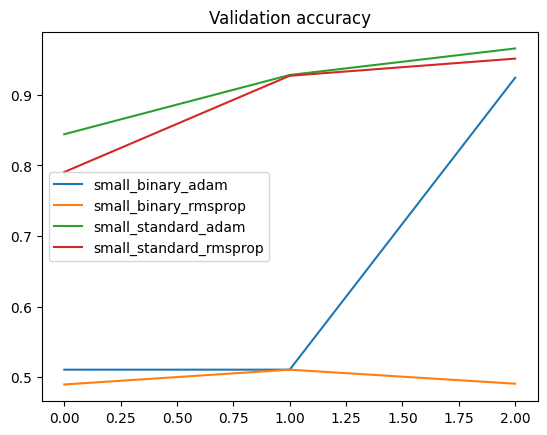

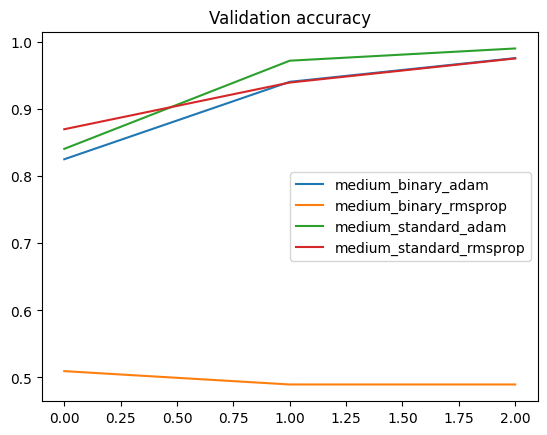

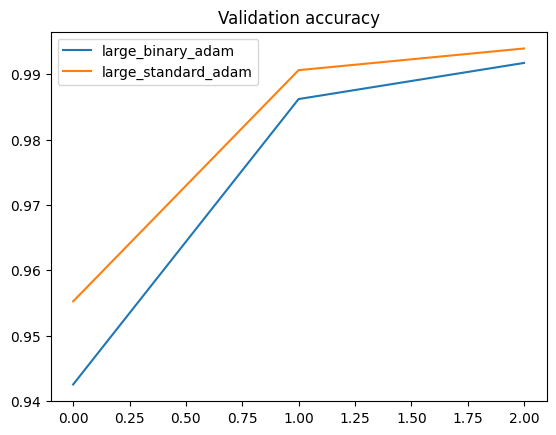

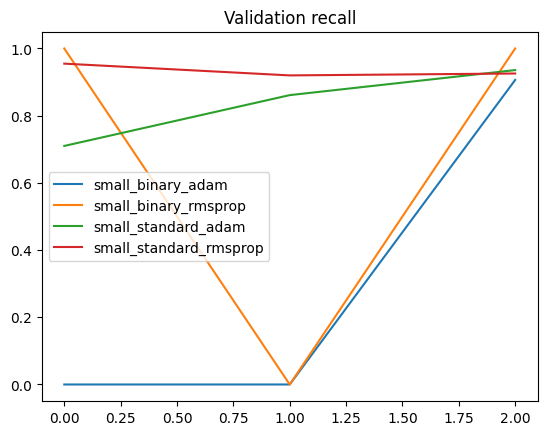

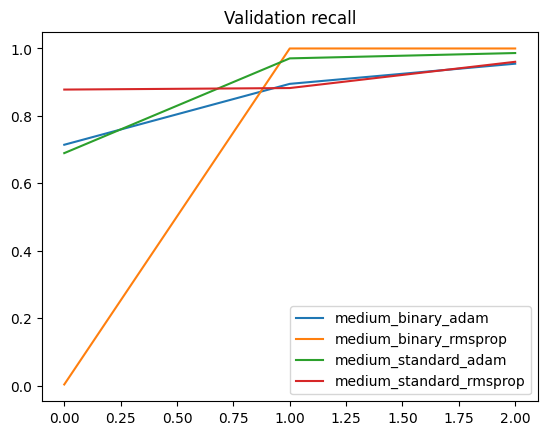

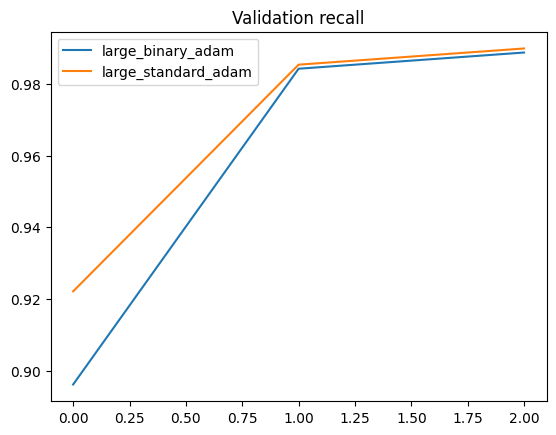

In [10]:
plot_diffrent_sizes(models)

In [11]:
models.keys()

dict_keys(['small_standard_adam', 'small_binary_adam', 'small_standard_rmsprop', 'small_binary_rmsprop', 'medium_standard_adam', 'medium_binary_adam', 'medium_standard_rmsprop', 'medium_binary_rmsprop', 'large_standard_adam', 'large_binary_adam', 'small_binary_lr=0.01_adam', 'small_binary_lr=0.001_adam', 'small_binary_lr=0.0001_adam', 'small_binary_lr=0.01_rmsprop', 'small_binary_lr=0.001_rmsprop', 'small_binary_lr=0.0001_rmsprop', 'small_binary_bs=32_adam', 'small_binary_bs=128_adam', 'small_binary_bs=256_adam', 'small_binary_bs=32_rmsprop', 'small_binary_bs=128_rmsprop', 'small_binary_bs=256_rmsprop'])

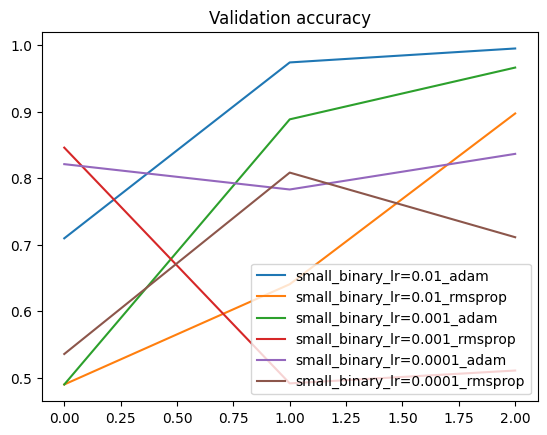

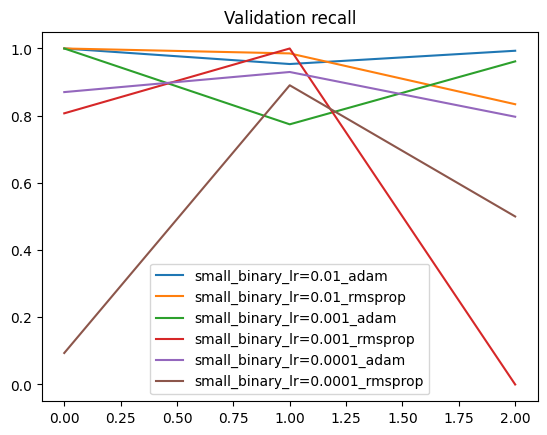

In [12]:
plot_diffrent_lr(models)

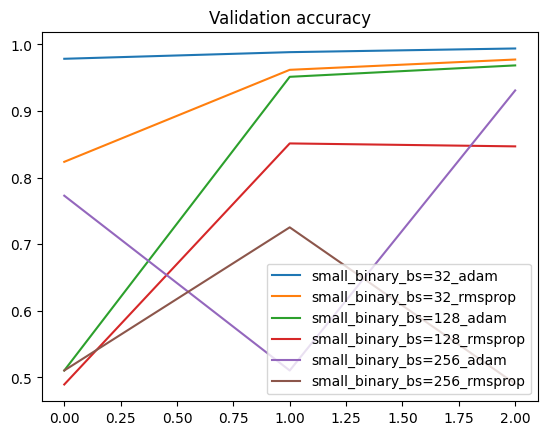

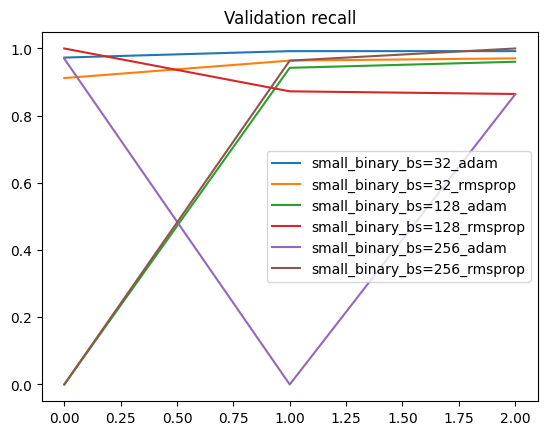

In [13]:
plot_diffrent_bs(models)

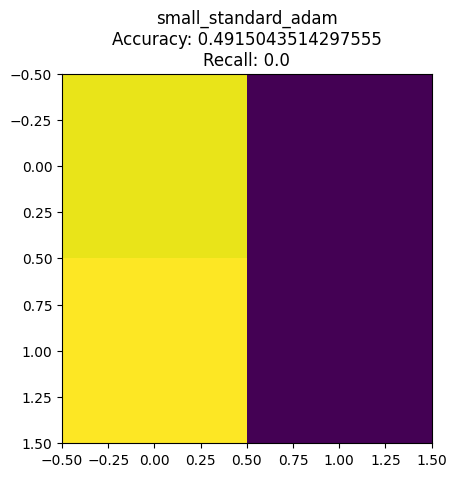

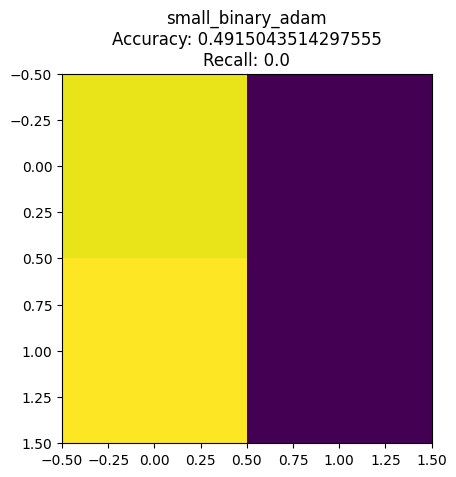

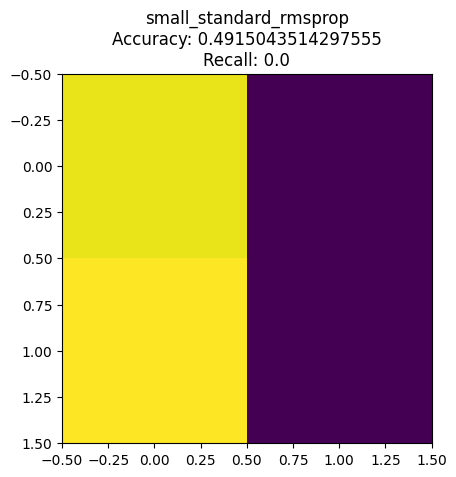

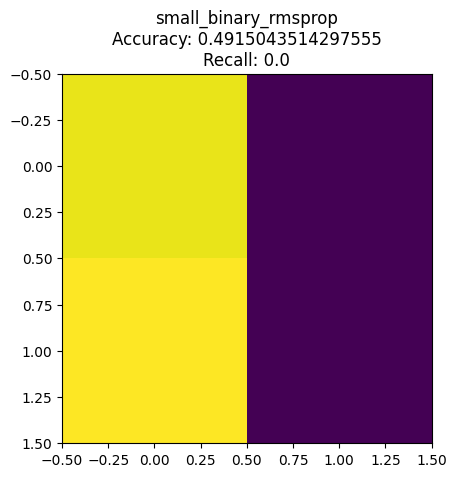

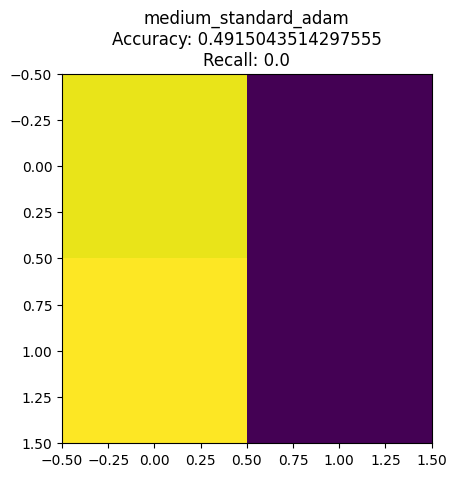

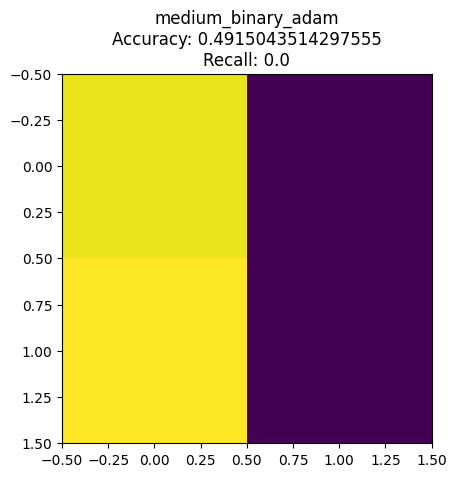

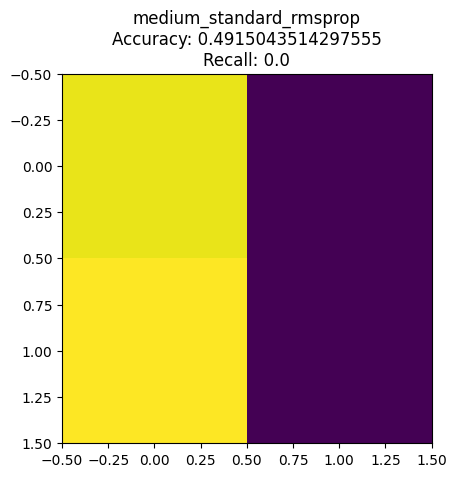

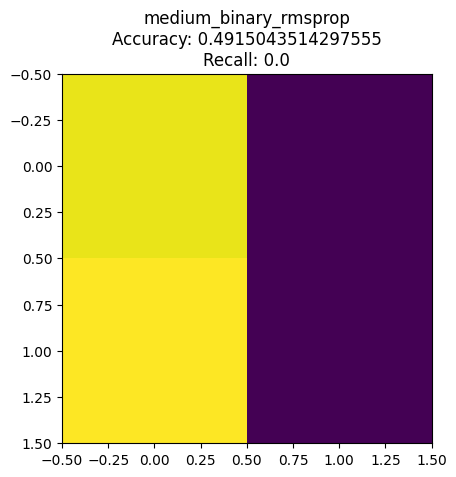

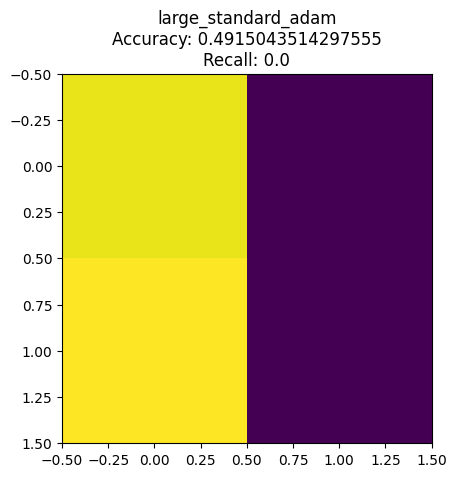

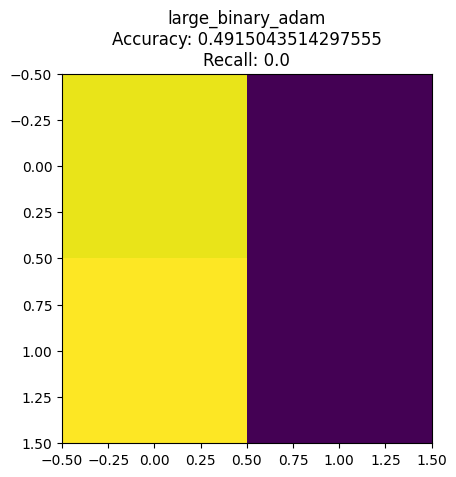

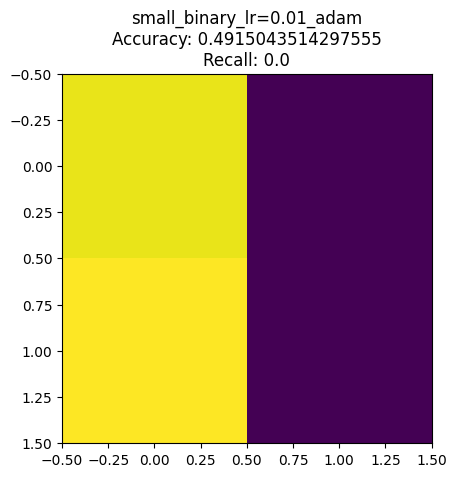

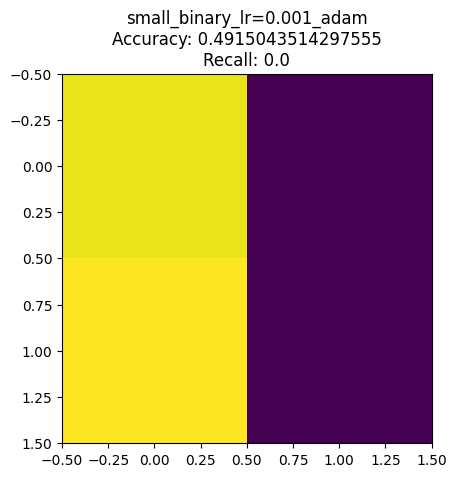

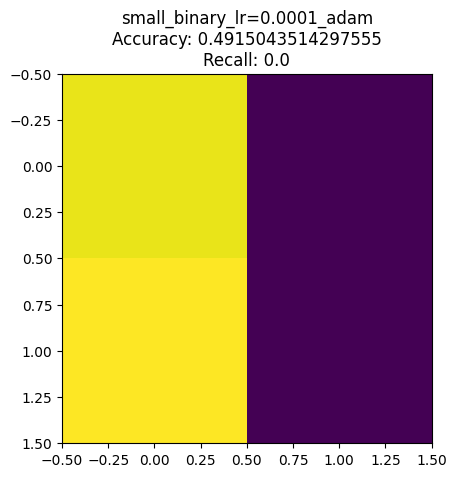

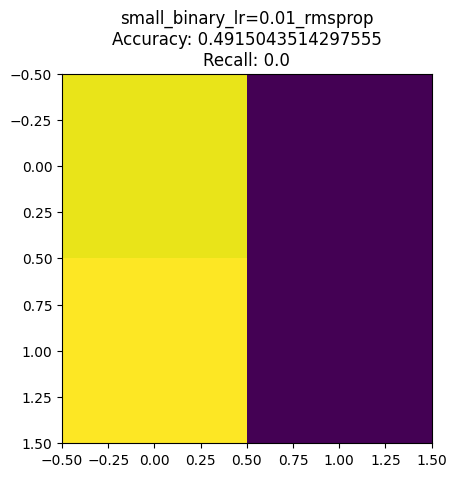

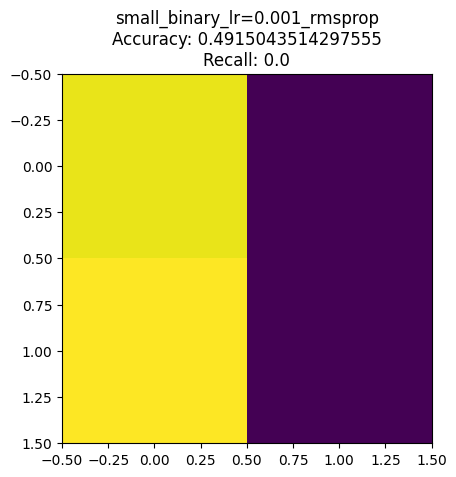

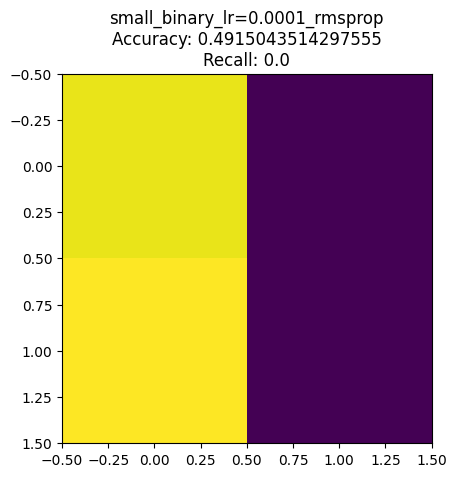

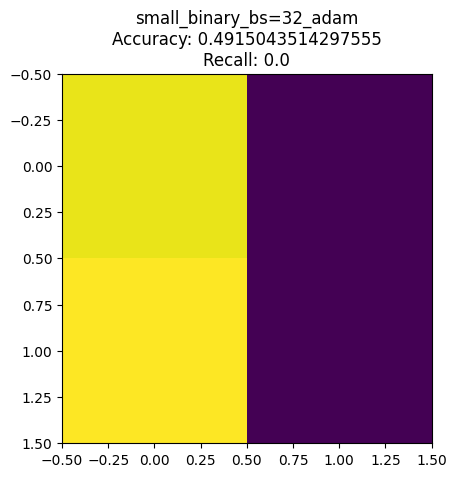

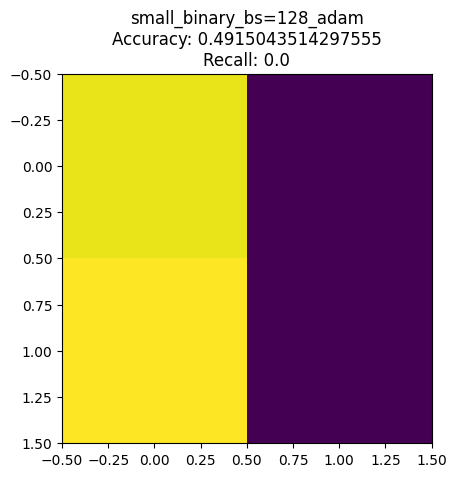

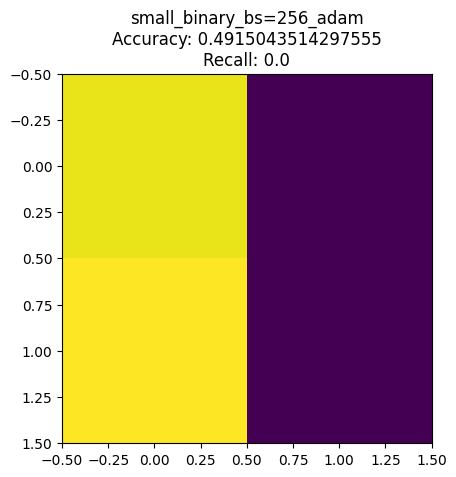

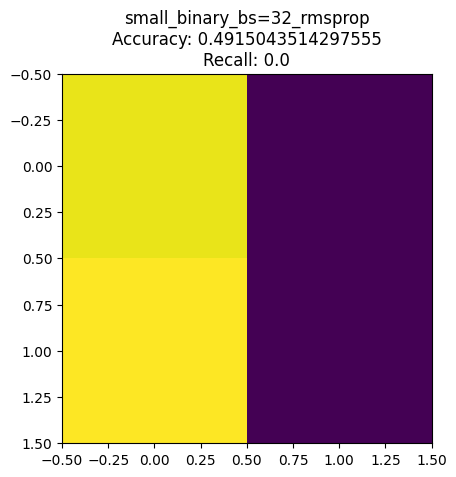

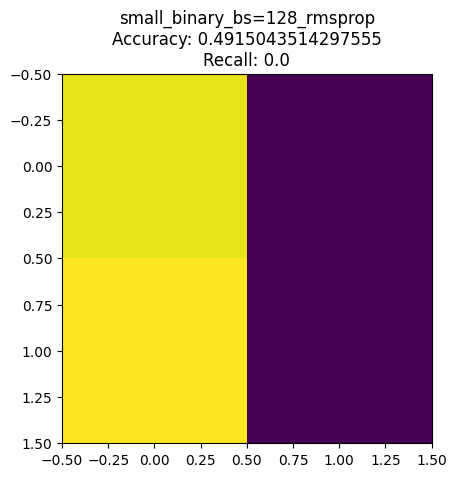

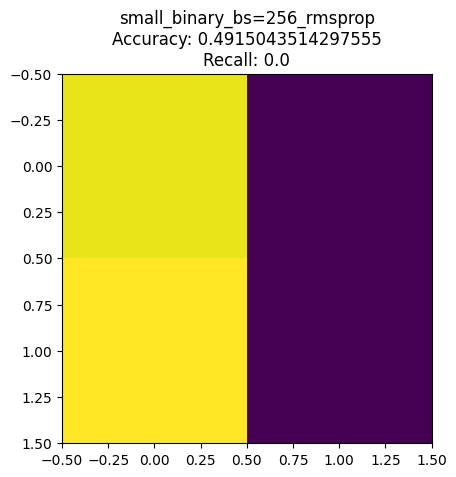

In [14]:
plot_cm(models)